In [1]:
library(Seurat)
library(tidyverse)
library(magrittr)
library(ggdendro)
library(reshape2)
library(viridis)
library(scales)
library(DirichletReg)
library(ComplexHeatmap)

set.seed(47)
setwd("~/Dropbox (MIT)/Zambia/")
options(repr.plot.width = 8, repr.plot.height = 8)
source("helper_scripts/plot_cluster_meta_percentage.R")
cell_color_scheme = readRDS("color_palette//cell_color_scheme.rdds")
setwd("~/Dropbox (MIT)/Zambia/reseq_analysis/histology_scoring")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.5
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths

Loading required package: viridisLite

Attaching package: ‘scales’

The following object is masked from ‘package:viridis’:

    viridis_pal

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: Formula
Loading required package: rgl
Loading r

In [2]:
combined = readRDS("../combined_iterate_jan13.rds")
combined_duo = subset(combined,region=="Duodenum") %>% subset(disease!="Stricture") %>% subset(HIV.HTLV.=="N")

Loading in histology

In [3]:
histology = read.csv("EED_histology_cleaned.csv")
# Extracting out the valid ranges for each scoring metric
ranges_for_histology = histology[1,]
names(ranges_for_histology) = colnames(histology)
ranges_for_histology = ranges_for_histology[-1]
ranges_for_histology = ranges_for_histology[-length(ranges_for_histology)]
# subsetting the histology down to just the values
histology = histology[-1,]
scores_histology = histology[,-1]
scores_histology = scores_histology[,-ncol(scores_histology)]
rownames(scores_histology) = histology[,1]
# subsetting down to the values for the EED patients
study_samples = unique(combined$old_orig)
study_histology = scores_histology[rownames(scores_histology) %in% study_samples,]
for(i in 1:ncol(study_histology)){
    study_histology[,i] = as.numeric(as.character(study_histology[,i]))
}
study_histology$sum = rowSums(study_histology)
# # getting the histology comments
comments = histology[,ncol(histology)]
names(comments) = histology[,1]
comments = comments[names(comments) %in% study_samples]

orig_key = distinct(combined@meta.data,orig.ident,old_orig)
for(i in 1:nrow(study_histology)){
    rownames(study_histology)[i] = orig_key$orig.ident[orig_key$old_orig==rownames(study_histology)[i]]
}

study_histology = study_histology[order(rownames(study_histology)),]

eed_histo = subset(combined,orig.ident%in%rownames(study_histology))
eed_only = subset(eed_histo,HIV.HTLV.=="N")
study_no_hiv = study_histology[rownames(study_histology)%in% unique(eed_only$orig.ident),]

colnames(study_no_hiv) = c("Acute LP Inflammation",
                         "Chronic LP Inflammation",
                          "Increased IEL Infiltration",
                          "Shortened Villus Architecture",
                          "Intramucosal Brunner's Glands",
                          "Decreased Goblet Density",
                          "Decreased Paneth Density",
                          "Increased Enterocyte Injury",
                          "Increased Epithelial Detachment",
                          "Increased Lymphoid Aggregates",
                          "Total Histological Score")

colnames(study_histology) = c("Acute LP Inflammation",
                         "Chronic LP Inflammation",
                          "Increased IEL Infiltration",
                          "Shortened Villus Architecture",
                          "Intramucosal Brunner's Glands",
                          "Decreased Goblet Density",
                          "Decreased Paneth Density",
                          "Increased Enterocyte Injury",
                          "Increased Epithelial Detachment",
                          "Increased Lymphoid Aggregates",
                          "Total Histological Score")

# Dirichlet regression analysis 

Over only HIV-, region specific effects regressed out

In [15]:
s_obj = eed_only
s_obj$cell_types = s_obj$tier4
s_obj$region = factor(s_obj$region,
                      levels=c("Duodenum","Bulb","Jejunum"))
all_counts = generate_all_counts(s_obj@meta.data)
sample_all_counts = generate_counts_by_sample(all_counts)
start = ncol(sample_all_counts)+1
sample_all_counts = cbind(sample_all_counts,study_no_hiv[,colSums(study_no_hiv)!=0])
sample_meta = generate_sample_meta(s_obj@meta.data)
sample_meta = sample_meta[order(sample_meta$orig.ident),]
sample_all_counts = cbind(sample_all_counts, region=sample_meta$region)
sample_all_counts = cbind(sample_all_counts, HIV.HTLV.=sample_meta$HIV.HTLV.)
end = ncol(sample_all_counts)
meta_cols = start:end
comp <- DR_data(sample_all_counts[, 1:(ncol(sample_all_counts)-length(meta_cols))])


get_pvals_and_coefs_dirichlet = function(model,metric,column=1){
    u = summary(model)
    pvals = u$coef.mat[grep(metric, rownames(u$coef.mat), invert=T), 4]
    v = names(pvals)
    pvals = matrix(pvals, ncol=length(u$varnames))
    colnames(pvals) = u$varnames
    dirichlet_pvals = pvals
    adjusted=p.adjust(dirichlet_pvals[column,],method="BH")
    dirichlet_coefs = model$coefficients[grep(metric,names(model$coefficients))]
    coef_sign = sign(dirichlet_coefs)
    return(data.frame(cell_type = names(adjusted),adj_p_value = adjusted,coef=dirichlet_coefs,sign=coef_sign))
}

Warning message in DR_data(sample_all_counts[, 1:(ncol(sample_all_counts) - length(meta_cols))]):
“not all rows sum up to 1 => normalization forced
  some entries are 0 or 1 => transformation forced”

In [17]:
model <- DirichReg(comp ~ `Total Histological Score` + region, sample_all_counts)
sig_types = get_pvals_and_coefs_dirichlet(model,'`Total Histological Score`')
sig_types$metric = 'Total Histological Score'

Call:
DirichReg(formula = comp ~ `Total Histological Score` + region, data =
sample_all_counts)

Standardized Residuals:
                            Min       1Q   Median       3Q      Max
B MS4A1                 -0.5659  -0.5480  -0.5383  -0.4665  -0.2641
DC                      -0.7028  -0.5323  -0.4394  -0.3000  -0.2291
EEC Delta               -0.6122  -0.5581  -0.5239  -0.4561  -0.2448
EEC I & L               -0.6176  -0.5552  -0.5169  -0.3924  -0.2791
EEC K                   -0.6178  -0.5448  -0.5246  -0.4641  -0.2800
EEC precursor           -0.5819  -0.5469  -0.4942  -0.4023  -0.3721
EEC X                   -0.6658  -0.5030  -0.4706  -0.4493  -0.2719
Endothelial             -0.7313  -0.5627  -0.5300  -0.4226   0.5312
Ent ANXA2 FABP1 CD55    -1.0180  -0.6062  -0.4881  -0.2844   8.1690
Ent ANXA2 PTMA          -0.8908  -0.6434  -0.5962  -0.3916   7.2407
Ent APOA ALPI           -2.0182  -1.0369   0.6580   3.5015   3.9811
Ent APOA PCK1           -0.5826  -0.5463  -0.5223  -0.4758  -0.

In [18]:
total_sig = sig_types %>% filter(adj_p_value < 0.05)
total_sig$sign = as.character(total_sig$sign)
total_sig$sign[total_sig$sign==1] ='Higher composition'
total_sig$sign[total_sig$sign==-1] ='Lower composition'
total_sig

cell_type,adj_p_value,coef,sign,metric
<fct>,<dbl>,<dbl>,<chr>,<chr>
Ent APOA ALPI,1.526876e-02,-0.00285617,Lower composition,Total Histological Score
Ent SI,7.229772e-04,0.03978644,Higher composition,Total Histological Score
Plasma cells,2.394090e-07,-0.18889582,Lower composition,Total Histological Score
Stem OLFM4,1.709398e-03,-0.05804046,Lower composition,Total Histological Score
T CD8 CCL5hi CD6hi,4.665031e-04,0.52155022,Higher composition,Total Histological Score
T CD8 MALAT1 XIST NKTR,3.081576e-03,0.42029552,Higher composition,Total Histological Score
T gamma delta GZMAhi,1.526876e-02,0.45942097,Higher composition,Total Histological Score


# Correlation Analysis

## Correlating cell type abundances with EE severity scores

In [4]:
s_obj = eed_only
s_obj$tier4 = as.factor(as.character(s_obj$tier4))
s_obj$cell_types = s_obj$tier4
unique_cells = unique(s_obj$cell_types)
histology_correlations= matrix(0,nrow = length(unique_cells),ncol = ncol(study_no_hiv))

s_obj$study = as.character(s_obj$study)
all_counts = generate_all_counts(s_obj@meta.data)
for(i in 1:length(unique_cells)){
    temp = all_counts %>% filter(cell_types==unique_cells[i])
    for(j in 1:ncol(study_no_hiv)){
        histology_correlations[i,j] = cor(temp$percent_of_sample,study_no_hiv[,j],method="spearman")
    }
}
rownames(histology_correlations) = unique_cells
colnames(histology_correlations) = colnames(study_no_hiv)
saveRDS(histology_correlations,"histology_composition_correlations.rds")

Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_s

In [6]:
s_obj = eed_only
s_obj$tier4 = as.factor(as.character(s_obj$tier4))
s_obj$cell_types = s_obj$tier4
unique_cells = unique(s_obj$cell_types)
histology_correlations= matrix(0,nrow = length(unique_cells),ncol = ncol(study_no_hiv))

s_obj$study = as.character(s_obj$study)
all_counts = generate_all_counts(s_obj@meta.data)
for(i in 1:length(unique_cells)){
    temp = all_counts %>% filter(cell_types==unique_cells[i])
    for(j in 1:ncol(study_no_hiv)){
        histology_correlations[i,j] = cor(temp$percent_of_sample,study_no_hiv[,j],method="pearson")
    }
}
rownames(histology_correlations) = unique_cells
colnames(histology_correlations) = colnames(study_no_hiv)
saveRDS(histology_correlations,"histology_composition_correlations_pearson.rds")

Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, s

In [20]:
histology_correlations  = readRDS("histology_composition_correlations.rds")

In [21]:
histology_correlations  = readRDS("histology_composition_correlations.rds")
histology_correlations = histology_correlations[,-c(1,3)]
histology_correlations = melt(histology_correlations)
colnames(histology_correlations)=c("cell_type","histology","correlation")
tier4_corrs = histology_correlations 
tier4_corrs$cell_type = as.character(tier4_corrs$cell_type)
tier4_corrs$cell_type[tier4_corrs$cell_type=="T CD8 CD4 CD6hi CD69lo"] = "T CD8 CCL5hi CD6hi"
tier4_corrs$cell_type[tier4_corrs$cell_type=="Brunner gland"] = "Bulb TFF1 GKN1"

t4_matrix = acast(tier4_corrs, histology~cell_type, value.var = "correlation")


## Complex heatmap plot

In [22]:
tier4_corrs$histology = factor(tier4_corrs$histology,levels = c(
                "Total Histological Score",
                "Shortened Villus Architecture",
                "Increased Enterocyte Injury",
                "Increased Epithelial Detachment",
                "Decreased Goblet Density",
                "Increased Lymphoid Aggregates",
                "Chronic LP Inflammation",
                "Intramucosal Brunner's Glands",
                "Decreased Paneth Density"))

ERROR: Error in parse(text = x, srcfile = src): <text>:11:0: unexpected end of input
9:                 "Intramucosal Brunner's Glands",
10:                 "Decreased Paneth Density")
   ^


In [37]:
num_splits = 4
histo_column_order = c(
                "Total Histological Score",
                "Shortened Villus Architecture",
                "Increased Enterocyte Injury",
                "Increased Epithelial Detachment",
                "Decreased Goblet Density",
                "Increased Lymphoid Aggregates",
                "Chronic LP Inflammation",
                "Intramucosal Brunner's Glands",
                "Decreased Paneth Density")
# t4_no_total = t4_matrix[-nrow(t4_matrix),]
t4_no_total = t4_matrix
cn = rownames(t4_no_total)
pdf("~/zambia_eed_figures/eed-metadata-figure/histology_tier4_complexheatmap.pdf",useDingbats = F,width=9,height=10)
Heatmap(t(t4_no_total),cluster_columns = F,column_order=histo_column_order,row_split = num_splits,row_names_gp = grid::gpar(fontsize = 8),
       row_title=rep("",num_splits),name="Spearman\ncorrelation",  show_column_names = FALSE,bottom_annotation = HeatmapAnnotation(
        text = anno_text(cn, rot = 50, offset = unit(1, "npc"), just = "right"),
        annotation_height = max_text_width(cn)))
dev.off()

Warning message:
“`offset` is deprecated, use `location` instead.”

pdf 
  2

## Epi and immune complex heatmap

In [2]:
histology_correlations  = readRDS("epi_histology_composition_correlations.rds")

histology_correlations = histology_correlations[,-c(1,3)]
histology_correlations = melt(histology_correlations)

[1]  9 23


Warning message:
“`offset` is deprecated, use `location` instead.”

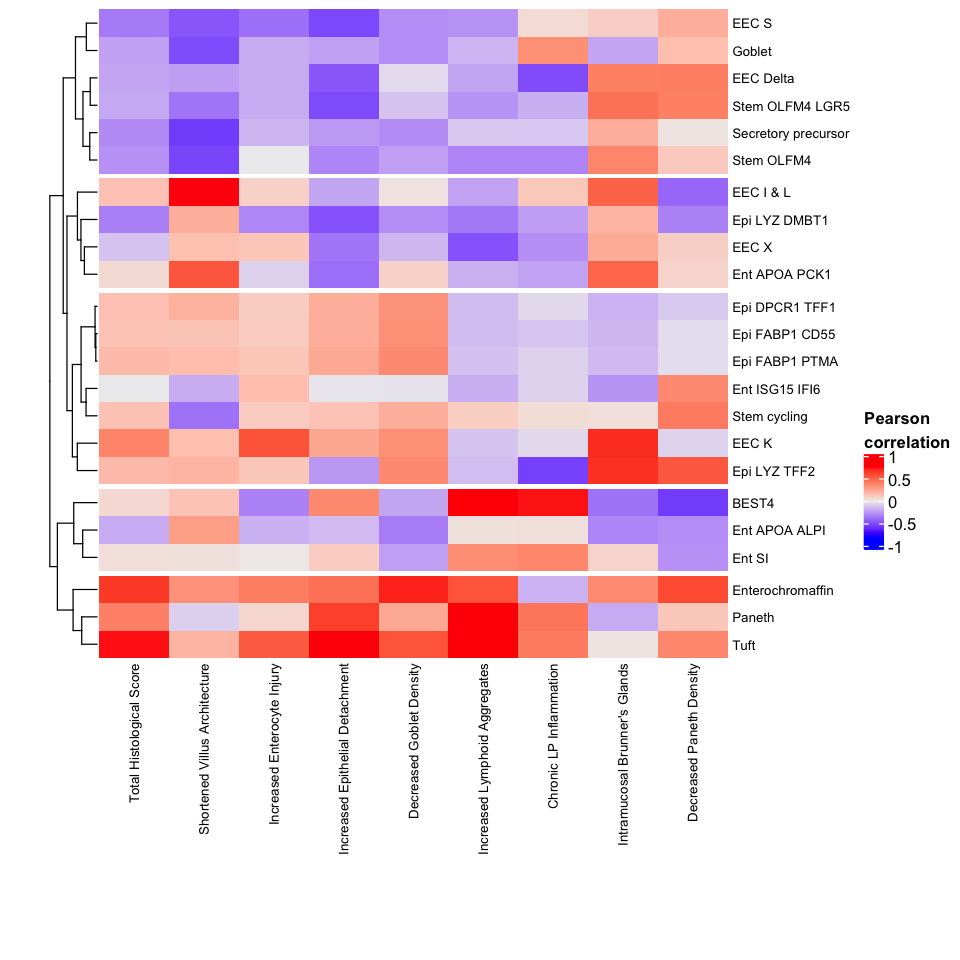

In [16]:
# Epi
histology_correlations  = readRDS("epi_histology_composition_correlations_pearson.rds")


histology_correlations = histology_correlations[,-c(1,3)]
histology_correlations = melt(histology_correlations)
colnames(histology_correlations)=c("cell_type","histology","correlation")
histology_correlations$cell_type = as.character(histology_correlations$cell_type)
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb TFF2 LYZ"] = "Epi LYZ TFF2"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb OLFM4"] = "Epi LYZ DMBT1"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb TFF1 GKN1"] = "Epi DPCR1 TFF1"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb FABP1"] = "Epi FABP1 CD55"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb PTMA"] = "Epi FABP1 PTMA"
histology_correlations$cell_type[histology_correlations$cell_type=="Ent HIV IFN"] = "Ent ISG15 IFI6"
histology_correlations$cell_type = as.factor(histology_correlations$cell_type)

tier4_corrs = histology_correlations 
tier4_corrs$cell_type = as.character(tier4_corrs$cell_type)
# tier4_corrs$cell_type[tier4_corrs$cell_type=="T CD8 CD4 CD6hi CD69lo"] = "T CD8 CCL5hi CD6hi"
tier4_corrs$cell_type[tier4_corrs$cell_type=="Brunner gland"] = "Bulb TFF1 GKN1"

t4_matrix = acast(tier4_corrs, histology~cell_type, value.var = "correlation")
print(dim(t4_matrix))
num_splits = 5
histo_column_order = c(
                "Total Histological Score",
                "Shortened Villus Architecture",
                "Increased Enterocyte Injury",
                "Increased Epithelial Detachment",
                "Decreased Goblet Density",
                "Increased Lymphoid Aggregates",
                "Chronic LP Inflammation",
                "Intramucosal Brunner's Glands",
                "Decreased Paneth Density")
# t4_no_total = t4_matrix[-nrow(t4_matrix),]
t4_no_total = t4_matrix
cn = rownames(t4_no_total)
# pdf("~/zambia_eed_figures/eed-metadata-figure/histology_tier4_complexheatmap_epi.pdf",useDingbats = F,width=4.5,height=6)
Heatmap(t(t4_no_total),cluster_columns = F,column_order=histo_column_order,row_split = num_splits,row_names_gp = grid::gpar(fontsize = 8),
       row_title=rep("",num_splits),name="Pearson\ncorrelation",  show_column_names = FALSE,bottom_annotation = HeatmapAnnotation(
        text = anno_text(cn, rot = 90, offset = unit(1, "npc"), just = "right",gp = gpar(fontsize = 8)),
        annotation_height = max_text_width(cn)))
# dev.off()

In [8]:
# immune
histology_correlations  = readRDS("immune_histology_composition_correlations_pearson.rds")

histology_correlations = histology_correlations[,-c(1,3)]
histology_correlations = melt(histology_correlations)
colnames(histology_correlations)=c("cell_type","histology","correlation")
histology_correlations$cell_type = as.character(histology_correlations$cell_type)
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb TFF2 LYZ"] = "Epi LYZ TFF2"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb OLFM4"] = "Epi LYZ DMBT1"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb TFF1 GKN1"] = "Epi DPCR1 TFF1"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb FABP1"] = "Epi FABP1 CD55"
histology_correlations$cell_type[histology_correlations$cell_type=="Bulb PTMA"] = "Epi FABP1 PTMA"
histology_correlations$cell_type[histology_correlations$cell_type=="Ent HIV IFN"] = "Ent ISG15 IFI6"
histology_correlations$cell_type[histology_correlations$cell_type=="T HIV IFN"] = "T CD8 IFI44 IFIT1"
histology_correlations$cell_type[histology_correlations$cell_type=="T CD4 CD69lo"] = "T CD4 CD69lo IL17A"
histology_correlations$cell_type = as.factor(histology_correlations$cell_type)
tier4_corrs = histology_correlations 
tier4_corrs$cell_type = as.character(tier4_corrs$cell_type)
tier4_corrs$cell_type[tier4_corrs$cell_type=="T CD8 CD4 CD6hi CD69lo"] = "T CD8 CCL5hi CD6hi"
# tier4_corrs$cell_type[tier4_corrs$cell_type=="Brunner gland"] = "Bulb TFF1 GKN1"

t4_matrix = acast(tier4_corrs, histology~cell_type, value.var = "correlation")
print(dim(t4_matrix))
num_splits = 5
histo_column_order = c(
                "Total Histological Score",
                "Shortened Villus Architecture",
                "Increased Enterocyte Injury",
                "Increased Epithelial Detachment",
                "Decreased Goblet Density",
                "Increased Lymphoid Aggregates",
                "Chronic LP Inflammation",
                "Intramucosal Brunner's Glands",
                "Decreased Paneth Density")
# t4_no_total = t4_matrix[-nrow(t4_matrix),]
t4_no_total = t4_matrix
cn = rownames(t4_no_total)
pdf("~/zambia_eed_figures/eed-metadata-figure/histology_tier4_complexheatmap_immune.pdf",useDingbats = F,width=4.8,height=6)
Heatmap(t(t4_no_total),cluster_columns = F,column_order=histo_column_order,row_split = num_splits,row_names_gp = grid::gpar(fontsize = 8),
       row_title=rep("",num_splits),name="Pearson\ncorrelation",  show_column_names = FALSE,bottom_annotation = HeatmapAnnotation(
        text = anno_text(cn, rot = 90, offset = unit(1, "npc"), just = "right",gp = gpar(fontsize = 8)),
        annotation_height = max_text_width(cn)))
dev.off()

[1]  9 24


Warning message:
“`offset` is deprecated, use `location` instead.”

pdf 
  2

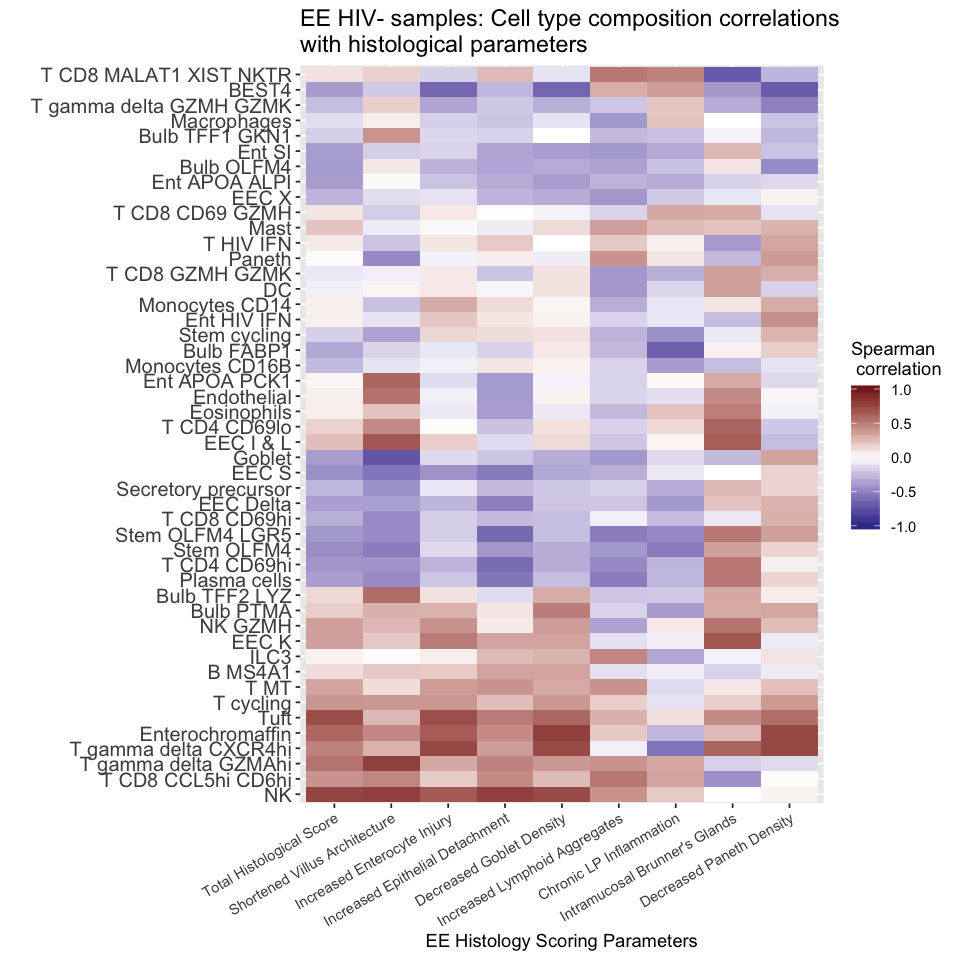

In [64]:
temp = tier4_corrs %>% filter()
ggplot(data=tier4_corrs,aes(x=histology,y=cell_type,fill=correlation)) +
    geom_tile(aes(width=1)) + scale_fill_gradient2(low=muted("blue"),high=muted('red'),limits=c(-1,1)) +
    theme(axis.text.x = element_text(angle = 30,hjust=1),
         axis.text.y=element_text(size=12),
         plot.title=element_text(size=14),
         legend.position="right")+
        ggtitle("EE HIV- samples: Cell type composition correlations\nwith histological parameters") +
    xlab("EE Histology Scoring Parameters") + ylab("")+
    labs(fill="Spearman \n correlation")

Running over epi t4

In [7]:
s_obj = subset(eed_only,tier1=="Epi")
s_obj$tier4 = as.factor(as.character(s_obj$tier4))
s_obj$cell_types = s_obj$tier4
unique_cells = unique(s_obj$cell_types)
histology_correlations= matrix(0,nrow = length(unique_cells),ncol = ncol(study_no_hiv))

s_obj$study = as.character(s_obj$study)
all_counts = generate_all_counts(s_obj@meta.data)
for(i in 1:length(unique_cells)){
    temp = all_counts %>% filter(cell_types==unique_cells[i])
    for(j in 1:ncol(study_no_hiv)){
        histology_correlations[i,j] = cor(temp$percent_of_sample,study_no_hiv[,j],method="spearman")
    }
}
rownames(histology_correlations) = unique_cells
colnames(histology_correlations) = colnames(study_no_hiv)
saveRDS(histology_correlations,"epi_histology_composition_correlations.rds")

Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_s

In [7]:
s_obj = subset(eed_only,tier1=="Epi")
s_obj$tier4 = as.factor(as.character(s_obj$tier4))
s_obj$cell_types = s_obj$tier4
unique_cells = unique(s_obj$cell_types)
histology_correlations= matrix(0,nrow = length(unique_cells),ncol = ncol(study_no_hiv))

s_obj$study = as.character(s_obj$study)
all_counts = generate_all_counts(s_obj@meta.data)
for(i in 1:length(unique_cells)){
    temp = all_counts %>% filter(cell_types==unique_cells[i])
    for(j in 1:ncol(study_no_hiv)){
        histology_correlations[i,j] = cor(temp$percent_of_sample,study_no_hiv[,j],method="pearson")
    }
}
rownames(histology_correlations) = unique_cells
colnames(histology_correlations) = colnames(study_no_hiv)
saveRDS(histology_correlations,"epi_histology_composition_correlations_pearson.rds")

Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, s

Running over immune t4

In [8]:
s_obj = subset(eed_only,tier1%in%c("TNK","B cells","Myeloid"))
s_obj$tier4 = as.factor(as.character(s_obj$tier4))
s_obj$cell_types = s_obj$tier4
unique_cells = unique(s_obj$cell_types)
histology_correlations= matrix(0,nrow = length(unique_cells),ncol = ncol(study_no_hiv))

s_obj$study = as.character(s_obj$study)
all_counts = generate_all_counts(s_obj@meta.data)
for(i in 1:length(unique_cells)){
    temp = all_counts %>% filter(cell_types==unique_cells[i])
    for(j in 1:ncol(study_no_hiv)){
        histology_correlations[i,j] = cor(temp$percent_of_sample,study_no_hiv[,j],method="spearman")
    }
}
rownames(histology_correlations) = unique_cells
colnames(histology_correlations) = colnames(study_no_hiv)
saveRDS(histology_correlations,"immune_histology_composition_correlations.rds")

Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "spearman"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_s

In [8]:
s_obj = subset(eed_only,tier1%in%c("TNK","B cells","Myeloid"))
s_obj$tier4 = as.factor(as.character(s_obj$tier4))
s_obj$cell_types = s_obj$tier4
unique_cells = unique(s_obj$cell_types)
histology_correlations= matrix(0,nrow = length(unique_cells),ncol = ncol(study_no_hiv))

s_obj$study = as.character(s_obj$study)
all_counts = generate_all_counts(s_obj@meta.data)
for(i in 1:length(unique_cells)){
    temp = all_counts %>% filter(cell_types==unique_cells[i])
    for(j in 1:ncol(study_no_hiv)){
        histology_correlations[i,j] = cor(temp$percent_of_sample,study_no_hiv[,j],method="pearson")
    }
}
rownames(histology_correlations) = unique_cells
colnames(histology_correlations) = colnames(study_no_hiv)
saveRDS(histology_correlations,"immune_histology_composition_correlations_pearson.rds")

Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, study_no_hiv[, j], method = "pearson"):
“the standard deviation is zero”Warning message in cor(temp$percent_of_sample, s

# Analyzing EE seveirty in HIV+ vs HIV- participants

In [5]:
temp = study_histology
temp$orig.ident = rownames(study_histology)

In [6]:
distinct_meta = eed_histo@meta.data %>% 
    distinct_at(vars(orig.ident),`.keep_all` = T) %>% 
    left_join(temp,by="orig.ident")

In [7]:
library(cowplot)


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [8]:
distinct_meta$HIV = "Negative"
distinct_meta$HIV[distinct_meta$HIV.HTLV.=="Y"]="Positive"
distinct_meta$HIV = factor(distinct_meta$HIV,levels=c("Positive","Negative"))

In [9]:
region_colors = readRDS("../region_colors.rds")

In [16]:
pdf("~/zambia_eed_figures/eed-metadata-figure/hiv_pos_neg_plot.pdf",useDingbats = F,width=8,height=4)
ggplot(distinct_meta,aes(x=HIV,y=`Total Histological Score`,color=region,group=region)) + 
    geom_point(size=6,position = position_dodge(width=0.4)) + 
    theme_cowplot()+
    xlab("HIV status") +
    ylab("Total histological EE severity")+
    scale_color_manual(values=region_colors)+
    labs(color="Intestinal region")
dev.off()

pdf 
  2

In [60]:
blah = eed_only@meta.data
blah = blah %>% left_join(temp,by="orig.ident")

In [65]:
wilcox.test(distinct_meta$`Total Histological Score`[distinct_meta$HIV=="Positive"],distinct_meta$`Total Histological Score`[distinct_meta$HIV=="Negative"])

Warning message in wilcox.test.default(distinct_meta$`Total Histological Score`[distinct_meta$HIV == :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  distinct_meta$`Total Histological Score`[distinct_meta$HIV ==  and distinct_meta$`Total Histological Score`[distinct_meta$HIV ==     "Positive"] and     "Negative"]
W = 50, p-value = 0.03363
alternative hypothesis: true location shift is not equal to 0
